<a href="https://colab.research.google.com/github/maxigaarp/Gestion-de-datos-2022/blob/main/Taller_3_Gesti%C3%B3n_de_datos_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo relacional**




En la primera parte de este taller, elaboraremos un modelo entidad-relación de una base de datos para estudiantes de educación superior de Chile.

Para ello considere que uno tiene la información para cada año, contando con el rut (codificado), el género, y la edad del estudiante. Al mismo tiempo, se cuenta con el año de ingreso a la carrera y el año de ingreso a la carrera de origen (Bachillerato, por ej. si existiese continuidad de estudios), el semestre de ingreso a la carrera, el semestre de ingreso a la carrera de orígen, el tipo de admisión que siguió para llegar a la carrera, el país donde realizó sus estudios previos, una variable binaria que indica si el estudiante está en proceso de titulación y el código único de la carrera que escogió.  

Además de este código, contamos con los siguientes datos de la carrera: la institución y sede en que se imparte la carrera, su nombre, su modalidad (presencial, semi o no presencial), su jornada, la versión (que refleja diferencia de carreras con igual nombre), el tipo de plan de la carrera, la duración teórica de la carrera, la duración teórica de la titulación, el nivel global de la carrera (Pregrado, postgrado o postitulo), dos categorías más para detallar el nivel de la carrera, sus requisitos de ingreso, el estado de vigencia de la carrera, su estado de acreditación, agencia acreditadora, fecha de acreditación, años de acreditación y los valores de la matricula, arancel, titulación y diploma. 

A su vez, todas las instituciones tienen un código, nombre y tipo, pueden estar acreditadas o no, y si están acreditadas es por una cantidad de años y por un periodo determinado. Por su parte, cada sede pertenece a una única institución y tiene los datos de su comuna, provincia y región.


Lo primero que haremos con este trabajo, será elaborar un modelo entidad-relación. Para ello, debemos investigar el esquema de registro y responder una serie de preguntas:



1.   ¿Qué entidades existen?
2.   ¿Cómo se relacionan estas entidades?
3.   ¿Cuáles son los atributos de cada entidad?
4.   ¿Cuál es la llave de cada entidad?



En https://app.creately.com/ podemos hacer el modelo mismo, gratis, sin grandes complicaciones. 

# **SQL en R**

Para esta parte del taller vamos a trabajar con la base de datos de la matricula de estudiantes de Educación superior del año 2020

Para ello, vamos a descargar la base de datos y, al mismo tiempo, vamos a descargar el esquema de registro de la tabla, que uno puede encontrar en los siguientes link

https://datosabiertos.mineduc.cl/matricula-en-educacion-superior/

https://datosabiertos.mineduc.cl/wp-content/uploads/2021/12/Matricula-Educacion-Superior-2020.rar

In [ ]:
install.packages("tictoc")
install.packages("data.table")
library("tictoc")
library(tidyverse)
library(data.table)
library(dplyr)
library(ggplot2)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [ ]:
install.packages("RSQLite")
library(RSQLite)

In [ ]:
system("gdown --id 1jDBPog5TrYaYgcnXTvyWecI90uccuWU2")

In [ ]:
unzip("/content/20200706_Matrcula_Ed_Superior_2020_PUBL_MRUN.zip")

In [ ]:
matricula <- fread("/content/20200706_Matrcula_Ed_Superior_2020_PUBL_MRUN.csv", "encoding" ="UTF-8")

In [ ]:
names(matricula)

In [ ]:
alumnos <- matricula[, c("MRUN", "GEN_ALU", "FEC_NAC_ALU")]
cursa <- matricula[,c("MRUN","codigo_unico", "cat_periodo", "rango_edad", "anio_ing_carr_ori", "sem_ing_carr_ori", "anio_ing_carr_act", "sem_ing_carr_act", "forma_ingreso")] 
carrera <- matricula[, c("codigo_unico",  "cod_carrera", "nomb_carrera", "modalidad", "jornada", "version", "tipo_plan_carr", "dur_estudio_carr", "dur_proceso_tit", "dur_total_carr", "nivel_global", "nivel_carrera_1", "nivel_carrera_2", "requisito_ingreso",  "vigencia_carrera", "valor_matricula", "valor_arancel", "codigo_demre", "area_conocimiento", "oecd_area",  "oecd_subarea", "area_carrera_generica", "acreditada_carr", "costo_proceso_titulacion",  "costo_obtencion_titulo_diploma" )]
se_imparte <-matricula[,c("codigo_unico", "cod_sede")]
sede <- matricula[,c( "cod_sede",  "nomb_sede", "region_sede", "provincia_sede", "comuna_sede")]
IES <- matricula[, c("cod_inst","tipo_inst_1", "tipo_inst_2", "tipo_inst_3", "nomb_inst", "acreditada_inst", "acre_inst_desde_hasta", "acre_inst_anio")]
pertenece_a <- matricula[,c( "cod_sede","cod_inst")]

In [ ]:
# Limpiar eliminando llaves vacíos


alumnos <- alumnos[!is.na(alumnos$MRUN), ]
cursa <- cursa[!is.na(cursa$MRUN), ]

In [ ]:
#Eliminamos información repetida
alumnos <- unique(alumnos)
carrera <- unique(carrera)
IES <- unique(IES)
sede <- unique(sede)


In [ ]:
cursa <- unique(cursa)
se_imparte <- unique(se_imparte)
pertenece_a <- unique(pertenece_a)

En primer lugar, generaremos una serie de consultas, para tratar de entender la tabla que tenemos

In [ ]:
conn <- dbConnect(RSQLite::SQLite(), "mineduc.db")

In [ ]:
dbWriteTable(conn , name = "IES", 
                  value = IES,
                  row.names = FALSE, overwrite = TRUE )
dbWriteTable(conn , name = "alumnos", 
                  value = alumnos,
                  row.names = FALSE, overwrite = TRUE )
dbWriteTable(conn , name = "carrera", 
                  value = carrera,
                  row.names = FALSE, overwrite = TRUE)
dbWriteTable(conn , name = "sede", 
                  value = sede,
                  row.names = FALSE, overwrite = TRUE)

dbWriteTable(conn , name = "pertenece_a", 
                  value = pertenece_a,
                  row.names = FALSE, overwrite = TRUE)
dbWriteTable(conn , name = "cursa", 
                  value = cursa,
                  row.names = FALSE, overwrite = TRUE)
dbWriteTable(conn , name = "se_imparte", 
                  value = se_imparte,
                  row.names = FALSE, overwrite = TRUE)


In [ ]:
# Encuentre el código de institución de la Pontificia Universidad Católica de Chile


dbGetQuery(conn, '
select 
cod_inst , nomb_inst
from IES 
where nomb_inst == "PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE";')


cod_inst,nomb_inst
<int>,<chr>
86,PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE


In [ ]:
# Genere una lista con todas las carreras diferentes, y sus nombres, que pertenecen al área OCDE Educación
dbGetQuery(conn, '
select 
codigo_unico, nomb_carrera
from carrera 
where oecd_area == "Educación";')


codigo_unico,nomb_carrera
<chr>,<chr>
I143S2C469J2V2,TECNICO ASISTENTE EN EDUCACION ESPECIAL
I155S2C65J1V1,TECNICO EN EDUCACION PARVULARIA
I71S1C149J1V1,PEDAGOGIA EN HISTORIA Y CIENCIAS SOCIALES / LICENCIATURA EN EDUCACION EN HISTORIA Y CIENCIAS SOCIALES
I80S1C18J1V2,PROFESOR DE EDUCACION FISICA
I143S2C469J1V1,TECNICO ASISTENTE EN EDUCACION ESPECIAL
I155S2C7J2V1,PSICOPEDAGOGIA
I71S1C44J1V1,PEDAGOGIA EN MATEMATICA Y COMPUTACION / LICENCIATURA EN EDUCACION EN MATEMATICA Y COMPUTACION
I70S1C442J1V1,PEDAGOGIA EN EDUCACION MEDIA EN MATEMATICAS Y FISICA
I69S1C261J1V1,PEDAGOGIA EN MATEMATICA


In [ ]:
# Entregue el nombre de todas las sedes que tiene la Universidad Católica
dbGetQuery(conn, '
select 
distinct nomb_sede
from sede, pertenece_a, 
where sede.cod_sede = pertenece_a.cod_sede
AND pertenece_a.cod_inst = 86;')


nomb_sede
<chr>
CAMPUS SAN JOAQUIN
SEDE LO CONTADOR
CASA CENTRAL
CAMPUS ORIENTE
SEDE VILLARRICA


In [ ]:
# Genere una tabla con la cantidad personas pertenecen a cada sede de la Universidad Católica
dbGetQuery(conn, '
select 
nomb_sede, count(cursa.MRUN) as "Alumnos"
from sede, cursa, pertenece_a, se_imparte, carrera 
where  cursa.codigo_unico = carrera.codigo_unico
and carrera.codigo_unico = se_imparte.codigo_unico
and se_imparte.cod_sede = sede.cod_sede
and sede.cod_sede = pertenece_a.cod_sede
and pertenece_a.cod_inst = 86
group by nomb_sede;')


nomb_sede,Alumnos
<chr>,<int>
CAMPUS ORIENTE,998
CAMPUS SAN JOAQUIN,25218
CASA CENTRAL,8755
SEDE LO CONTADOR,2294
SEDE VILLARRICA,251


In [ ]:
# Genere una tabla de la cantidad de sedes por institución y grafiquela
sedes <- dbGetQuery(conn, '
select 
nomb_inst, count(distinct(pertence_a.cod_sede)) as "Cantidad_Sedes"
from  IES, pertenece_a 
where  and pertenece_a.cod_inst = IES.cod_inst 
group by pertenece_a.cod_inst;')
sedes


nomb_inst,Cantidad_Sedes
<chr>,<int>
UNIVERSIDAD GABRIELA MISTRAL,1
UNIVERSIDAD FINIS TERRAE,1
UNIVERSIDAD DIEGO PORTALES,1
UNIVERSIDAD CENTRAL DE CHILE,4
UNIVERSIDAD BOLIVARIANA,9
UNIVERSIDAD PEDRO DE VALDIVIA,5
UNIVERSIDAD MAYOR,10
UNIVERSIDAD ACADEMIA DE HUMANISMO CRISTIANO,2
UNIVERSIDAD SANTO TOMAS,14


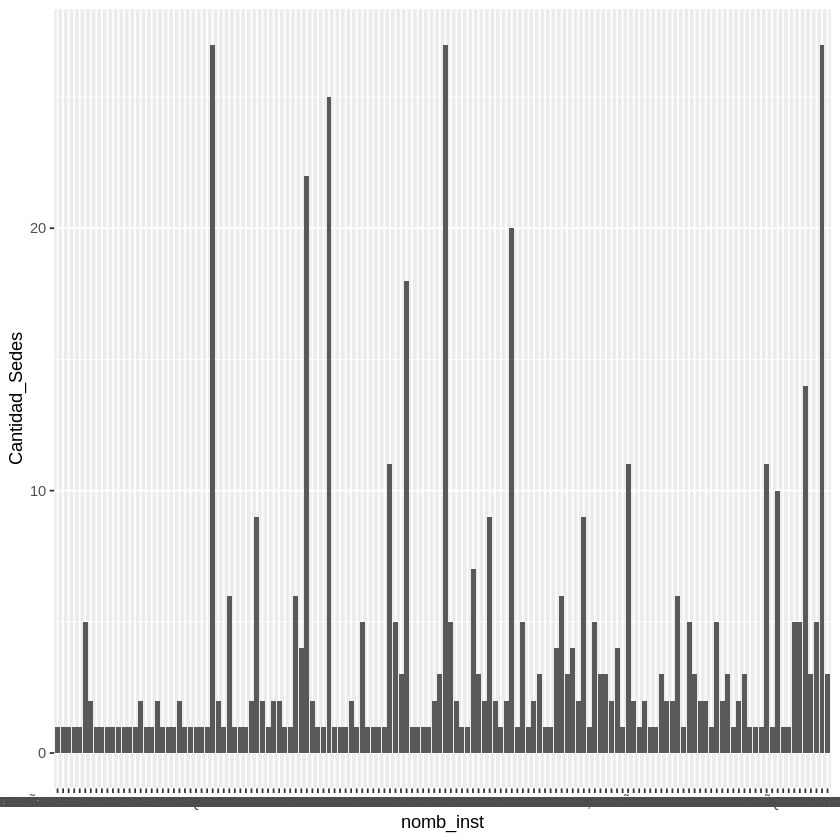

In [ ]:
sedes %>%  ggplot(aes(x=nomb_inst,y=Cantidad_Sedes)) + 
            geom_bar(stat="identity", position="stack")


In [ ]:
# Grafique que regiones tienen mayor cantidad de alumnos
sedes <- dbGetQuery(conn, '
select 
region_sede, count(cursa.MRUN) as "Alumnos_Region"
from sede, se_imparte, carrera, cursa
where  cursa.codigo_unico = carrera.codigo_unico
and carrera.codigo_unico = se_imparte.codigo_unico
and se_imparte.cod_sede = sede.cod_sede
group by sede.region_sede;')
sedes

region_sede,Alumnos_Region
<chr>,<int>
Antofagasta,39008
Arica y Parinacota,16757
Atacama,12087
Aysén,2888
Biobío,127683
Coquimbo,42641
La Araucanía,58653
Lib. Gral B. O'Higgins,27265
Los Lagos,42119


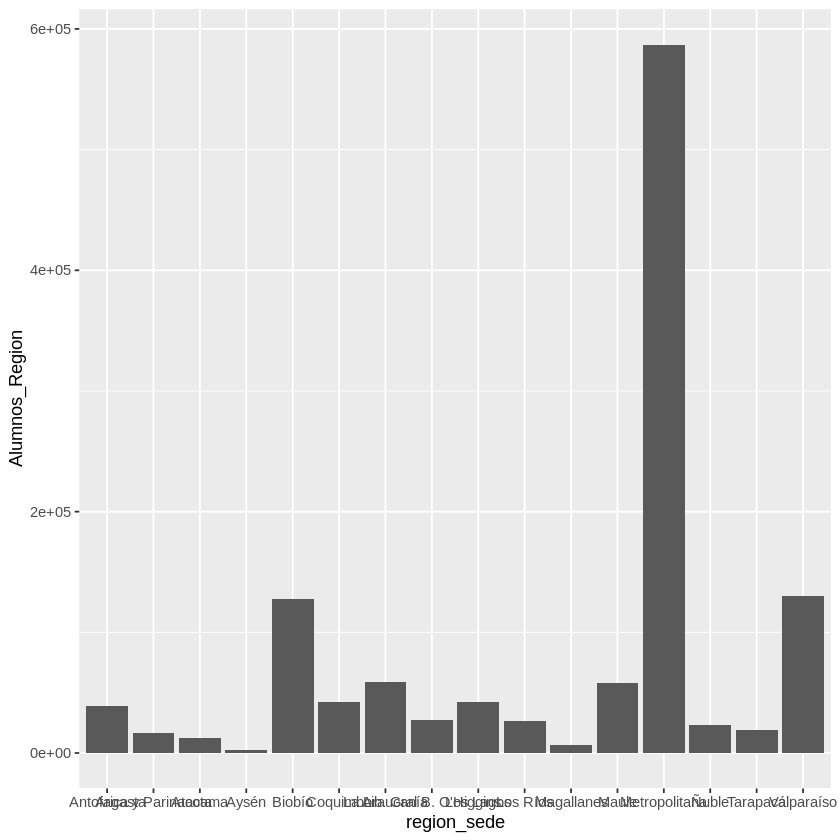

In [ ]:

sedes %>%  ggplot(aes(x=region_sede,y=Alumnos_Region)) + 
            geom_bar(stat="identity", position="stack")

**Actividad**

Ralice las siguientes consultas, graficando cuando sea necesario


1.   Identifique la cantidad de alumnos que estudian en el sector OCDE "Educación" por cada región, y grafíquelo
2.   Determine la cantidad de estudiantes de postgrado pertenecen a cada tipo de institución
3.   Determine las comunas en que se encuentren las carreras de mayor duración, considerando solo instituciones acreditadas

